# Object Detection with Detectron2

## Imports

In [21]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import cv2
import random
import numpy as np
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Register Dataset

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wheat_train", {}, "data/wheat_ear/annotations/instances_train2017.json", "data/wheat_ear/images")
register_coco_instances("wheat_val", {}, "data/wheat_ear/annotations/instances_val2017.json", "data/wheat_ear/images")

## Config for training

In [2]:
cfg = get_cfg()

In [25]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wheat_train",)
cfg.DATASETS.TEST = ("wheat_val",)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml") # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500

## Training

In [4]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/12 10:34:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!


[06/12 10:34:27 d2.engine.train_loop]: Starting training from iteration 0
[06/12 10:34:37 d2.utils.events]:  eta: 0:12:33  iter: 19  total_loss: 1.913  loss_cls: 0.741  loss_box_reg: 0.883  loss_rpn_cls: 0.267  loss_rpn_loc: 0.034  time: 0.4963  data_time: 0.0096  lr: 0.000020  max_mem: 4394M
[06/12 10:34:47 d2.utils.events]:  eta: 0:11:42  iter: 39  total_loss: 1.659  loss_cls: 0.605  loss_box_reg: 0.889  loss_rpn_cls: 0.125  loss_rpn_loc: 0.032  time: 0.4878  data_time: 0.0047  lr: 0.000040  max_mem: 4395M
[06/12 10:34:57 d2.utils.events]:  eta: 0:11:58  iter: 59  total_loss: 1.530  loss_cls: 0.526  loss_box_reg: 0.920  loss_rpn_cls: 0.046  loss_rpn_loc: 0.031  time: 0.4933  data_time: 0.0044  lr: 0.000060  max_mem: 4395M
[06/12 10:35:07 d2.utils.events]:  eta: 0:11:49  iter: 79  total_loss: 1.502  loss_cls: 0.489  loss_box_reg: 0.955  loss_rpn_cls: 0.041  loss_rpn_loc: 0.025  time: 0.4951  data_time: 0.0043  lr: 0.000080  max_mem: 4395M
[06/12 10:35:17 d2.utils.events]:  eta: 0:11:3

## Testing on a single image

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55
# cfg.DATASETS.TEST = ("deepfashion_val", )
predictor = DefaultPredictor(cfg)

In [9]:
im = cv2.imread("../../data/wheat_ear/images/000009.jpg")
outputs = predictor(im)

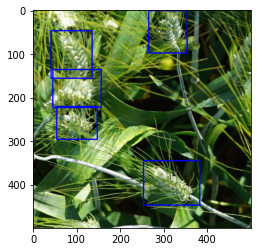

<Figure size 1440x1440 with 0 Axes>

True

In [29]:
import uuid 
from matplotlib import pyplot as plt

boxes = {}
for coordinates in outputs["instances"].to("cpu").pred_boxes:
    coordinates_array = []
    for k in coordinates:
        coordinates_array.append(int(k))

    boxes[uuid.uuid4().hex[:].upper()] = coordinates_array 
    new_image = im
    for k,v in boxes.items():
#         crop_img = im[v[1]:v[3], v[0]:v[2], :]
        new_image = cv2.rectangle(new_image, (v[0],v[1]), (v[2], v[3]), (255, 0, 0), 2) 
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(20,20))
plt.show()
cv2.imwrite('image.jpg', new_image)
#     cv2.imwrite(k + '.jpg', crop_img)
    
    